In [142]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os #для работы с операционной сист.

#import PIL
from PIL import Image
import pandas as pd
import numpy as np
import pathlib
import glob 


import warnings
warnings.filterwarnings('ignore')

In [143]:
# импорт библиотек
train_dataset = pd.read_csv('C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/train_data.csv', header = None)
test_dataset = pd.read_csv('C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/test_data.csv', header = None)
train_dataset.head()

,0,1,2
0,033/02_033.png,033_forg/03_0203033.PNG,1
1,033/02_033.png,033_forg/04_0213033.PNG,1
2,033/02_033.png,033_forg/02_0213033.PNG,1
3,033/02_033.png,033_forg/04_0203033.PNG,1
4,033/02_033.png,033_forg/01_0205033.PNG,1


In [144]:
train_dataset.shape

(13642, 3)

In [145]:
train_dataset.isnull().sum()

0    0
1    0
2    0
dtype: int64

In [146]:
train_dir = "C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/train/"
test_dir = "C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/test/"

In [147]:
train_img = pathlib.Path(train_dir)
pattern = train_dir +"*/*.png"
photos_train = glob.glob(pattern)
# photos_train

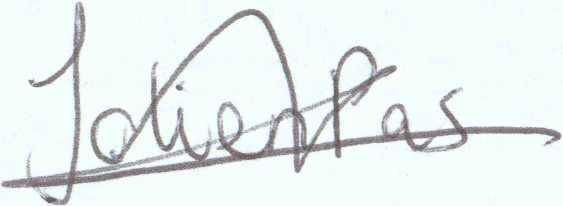

In [148]:
PIL.Image.open(photos_train[52])

In [149]:
train_set, val_set = train_test_split(train_dataset, test_size=0.2, random_state=42, shuffle=True)

In [150]:
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1) #декодируем изобр png из строки байтов в тензор TensorFlow
    img = tf.image.resize(img, (150, 150))
    img = tf.cast(img, tf.float32) / 255.0 #нормализация
    
    return img

In [151]:
# Генератор данных
def data_generator(dataset, dir, batch_size):
    while True:
        for index in range(0, len(dataset), batch_size):
            batch = dataset.iloc[index:index+batch_size]
            images1 = []
            images2 = []
            labels = []
            for i, row in batch.iterrows():
                image1_path = os.path.join(dir, row[0])
                image2_path = os.path.join(dir, row[1])
                
                # Проверка наличия изображения перед чтением
                if not (os.path.exists(image1_path) and os.path.exists(image2_path)):
                    continue  # Если одно изображение отсутствует, пропускаем эту строку
                
                image1_data = preprocess_image(image1_path)
                image2_data = preprocess_image(image2_path)
                label = np.array(row[2], dtype=np.float32)
                images1.append(image1_data)
                images2.append(image2_data)
                labels.append(label)
            inputs = {"image1": np.array(images1), "image2": np.array(images2)}
            targets = np.array(labels)
            yield inputs, targets

In [152]:
batch_size = 128

In [153]:
#Создание генераторов данных
generator_train = data_generator(train_set, train_dir, batch_size)
generator_val = data_generator(val_set, train_dir, batch_size)

In [154]:
# train_length = 0
# for _ in generator_train:
#     train_length += 1
# print(train_length)

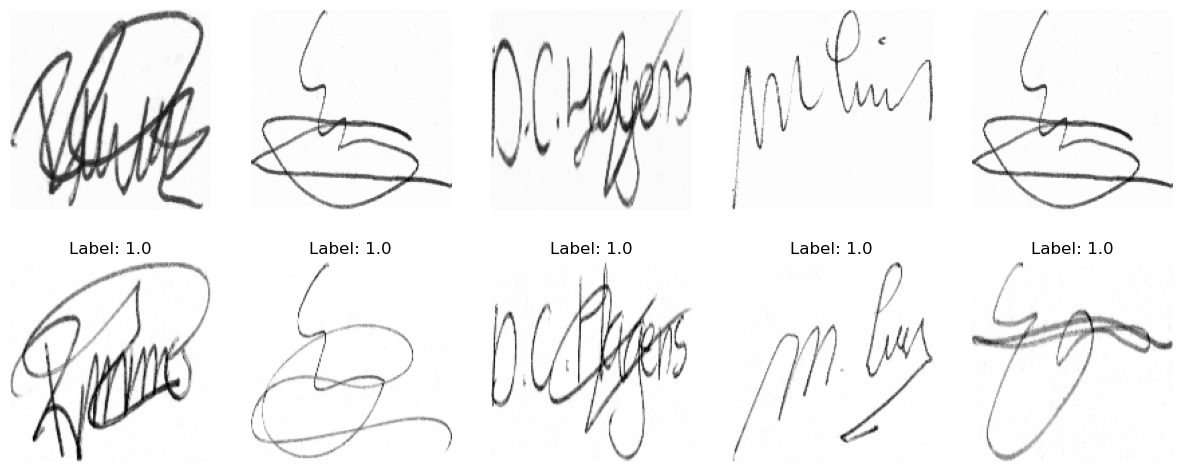

In [155]:
# Получаем первый батч данных из генератора
batch_images, batch_labels = next(generator_train)

# Отображаем первые пять пар изображений и их метки
plt.figure(figsize=(15, 6))
for i in range(5):
    # Получаем изображения и метку для текущей пары
    image1 = batch_images['image1'][i]
    image2 = batch_images['image2'][i]
    label = batch_labels[i]

    # Отображаем изображения
    plt.subplot(2, 5, i+1)
    plt.imshow(image1.squeeze(), cmap='gray')  # Отображаем изображение 1
    plt.axis('off')
#squeeze() используется для удаления размерности с единственным элементом (например, изображение может иметь размерность (1, 150, 150, 1), а squeeze() убирает размерность с единственным элементом, оставляя (150, 150)). plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(image2.squeeze(), cmap='gray')  # Отображаем изображение 2
    plt.axis('off')

    # Выводим метку
    plt.title(f"Label: {label}")

plt.show()


In [156]:

def create_siamese_model(input_shape):
# Определение базовой модели CNN
    base_model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(128, activation='relu')
    ])
    
    # Определение входов для пар изображений
    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    # Применение базовой модели к каждому изображению
    embedding1 = base_model(input1)
    embedding2 = base_model(input2)

    # Определение слоя, вычисляющего расстояние Манхэттена между эмбеддингами
    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])

    # Создание выходного слоя с сигмоидной активацией
    output = Dense(1, activation='sigmoid')(manhattan_distance)

    # Создание модели
    siamese_model = Model(inputs=[input1, input2], outputs=output)

    return siamese_model

In [157]:
input_shape = (150, 150, 1) 

In [158]:
model = create_siamese_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 150, 150,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 150, 150,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 128)       │  3,374,592 │ image1[0][0],     │
│ (Sequential)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128)       │          0 │ sequential_2[0][… │
│                     │                   │            │ sequential_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ lambda_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,374,721 (12.87 MB)

 Trainable params: 3,374,721 (12.87 MB)

 Non-trainable params: 0 (0.00 B)

In [159]:
checkpoint = ModelCheckpoint("model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

callbacks_list = [checkpoint, early_stopping]

In [161]:
sper_epoch = len(train_set) // batch_size  # Количество шагов на каждой эпохе
val_steps = len(val_set) // batch_size  # Количество шагов валидации на каждой эпохе
# Обучение модели
history = model.fit(generator_train,
                    epochs=10,
                    steps_per_epoch=sper_epoch,
                    validation_data=generator_val,
                    validation_steps=val_steps,
                    callbacks=callbacks_list,
                    verbose = 1)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9952 - loss: 0.0361
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.9952 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 0.0187
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9947 - loss: 0.0356
Epoch 2: val_accuracy did not improve from 1.00000
85/85 ━━━━━━━━━━━━━━━━━━━━ 13s 158ms/step - accuracy: 0.9947 - loss: 0.0355 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9967 - loss: 0.0293
Epoch 3: val_accuracy did not improve from 1.00000
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.9967 - loss: 0.0293 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9969 - loss: 0.0253
Epoch 4: val_accuracy did not improve from 1.00000
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.9969 - loss:

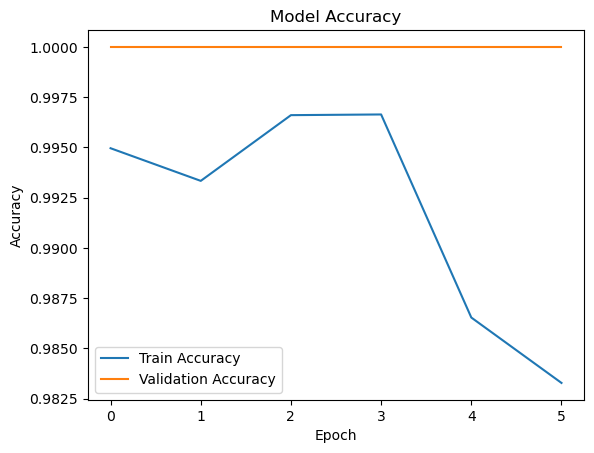

In [162]:
# Визуализация точности и валидационной точности
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [163]:
# Загрузка лучшей модели
model.load_weights("model.keras")

In [164]:
test_dir = "C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/test/"
test_set = pd.read_csv('C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/test_data.csv', header = None)

In [165]:
generator_test = data_generator(test_set, test_dir, batch_size)

In [166]:
test_steps = len(test_set) // batch_size

In [167]:
# Оценка модели на тестовом наборе
test_loss, test_accuracy = model.evaluate(generator_test,
                                          steps=test_steps)

44/44 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9947 - loss: 0.1590


In [168]:
# Получение пар изображений и их меток для тестового набора данных
test_pairs, test_labels = next(generator_test)

In [170]:
# Получение предсказаний для тестового набора данных
test_predictions = model.predict(test_pairs)

# Преобразование предсказаний в бинарный формат (0 или 1)
binary_predictions = (test_predictions > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


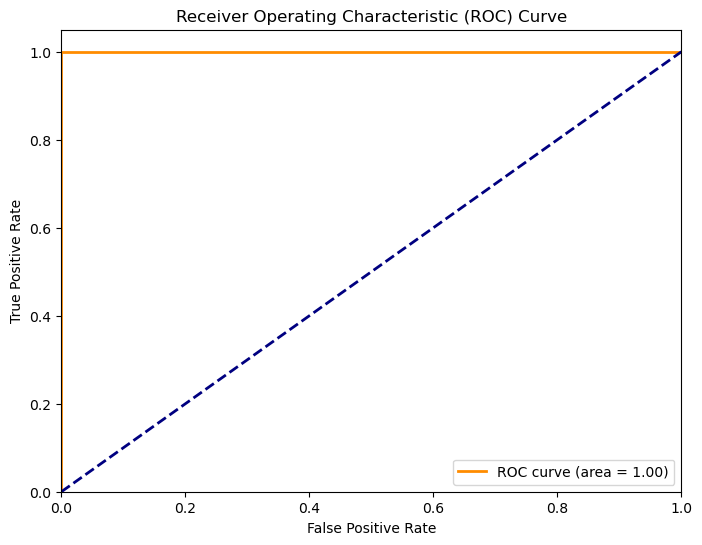

In [171]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_labels, binary_predictions)
# Вычисление площади под ROC-кривой (AUC)
roc_auc = auc(fpr, tpr)
# Вывод ROC-AUC графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [172]:
len(test_pairs['image1'])

128

Pair 62
True Label: 1.0
Predicted Label: [1]


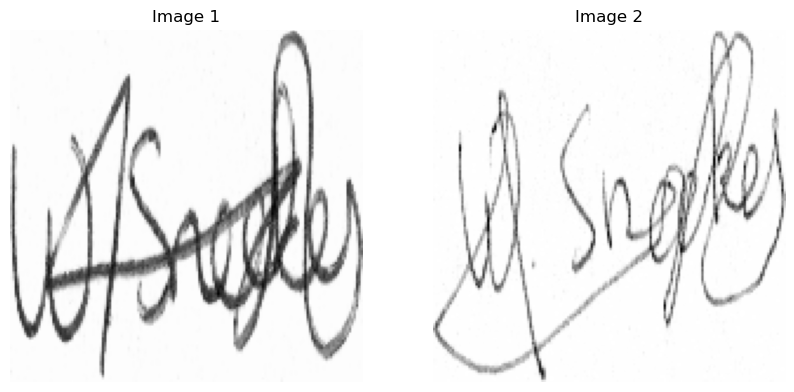

Pair 50
True Label: 1.0
Predicted Label: [1]


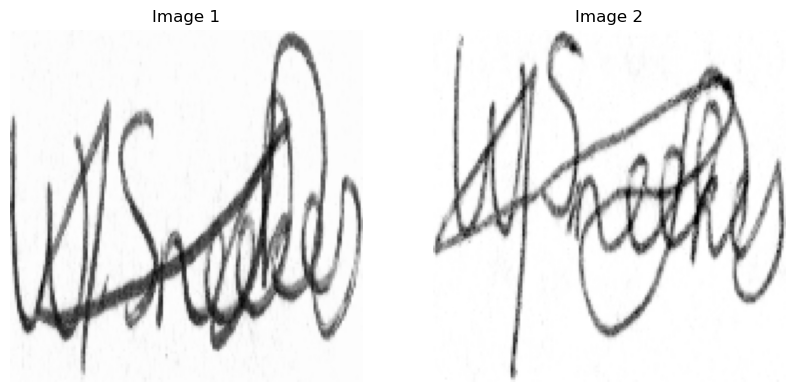

Pair 71
True Label: 1.0
Predicted Label: [1]


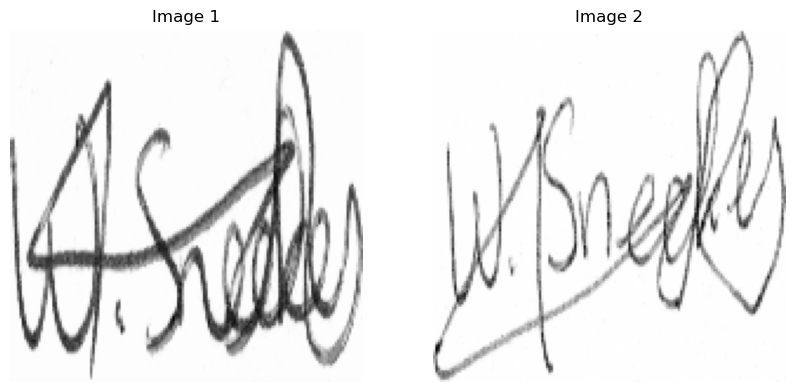

Pair 7
True Label: 1.0
Predicted Label: [1]


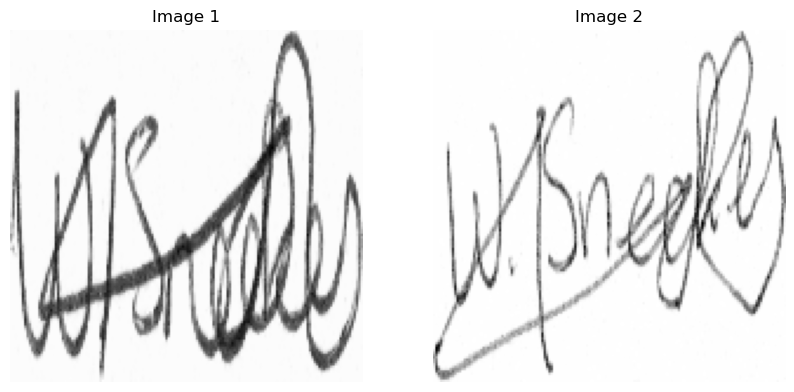

Pair 126
True Label: 0.0
Predicted Label: [0]


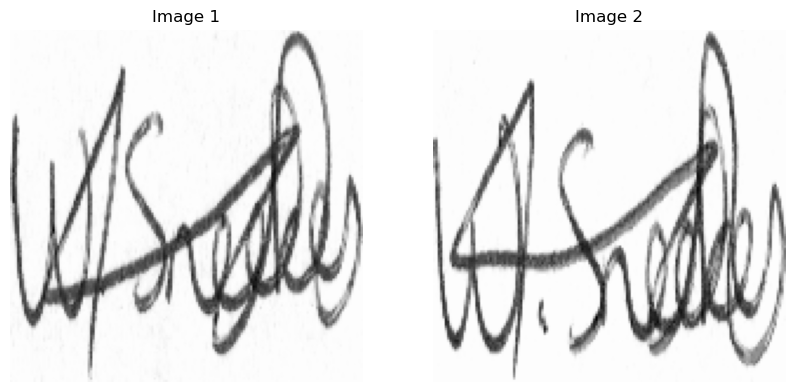

Pair 44
True Label: 1.0
Predicted Label: [1]


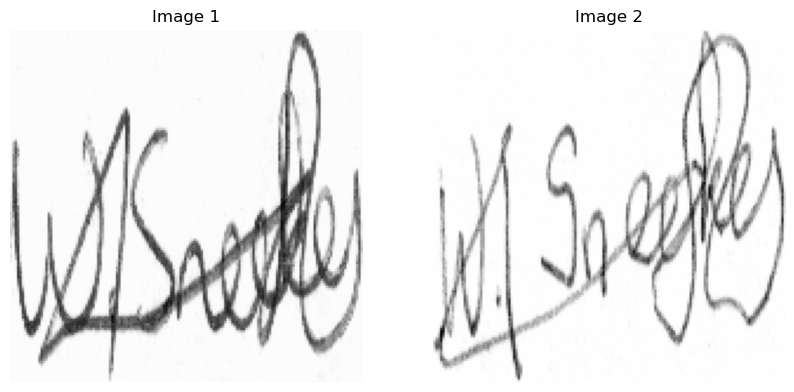

Pair 60
True Label: 1.0
Predicted Label: [1]


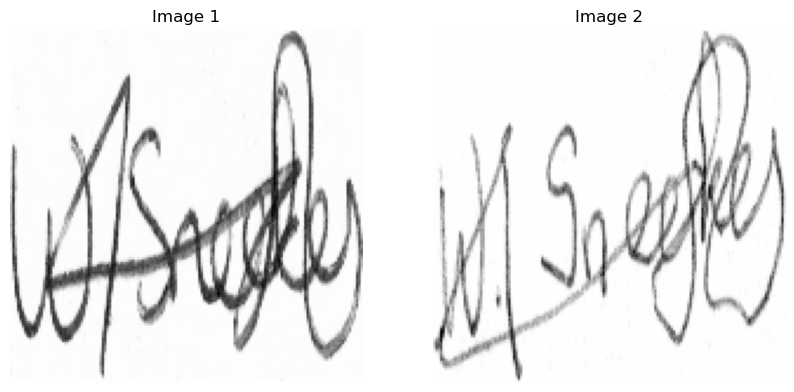

Pair 41
True Label: 1.0
Predicted Label: [1]


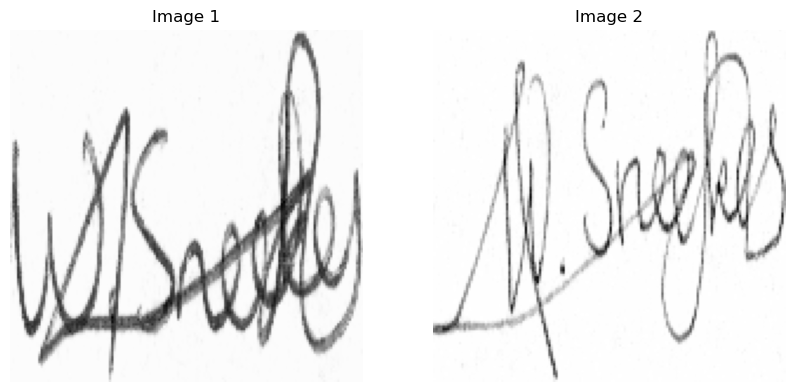

Pair 5
True Label: 1.0
Predicted Label: [1]


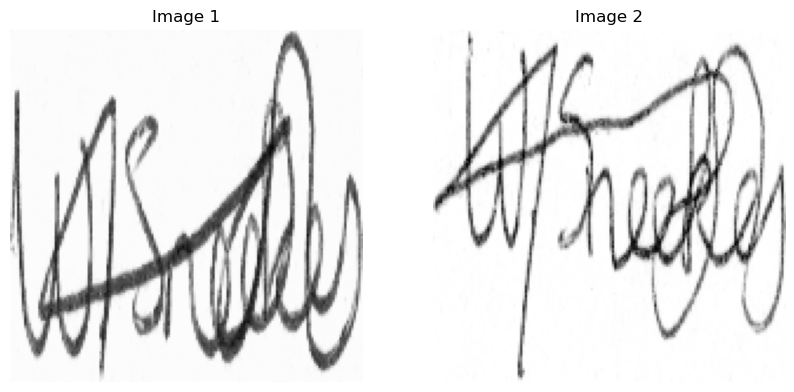

Pair 66
True Label: 1.0
Predicted Label: [1]


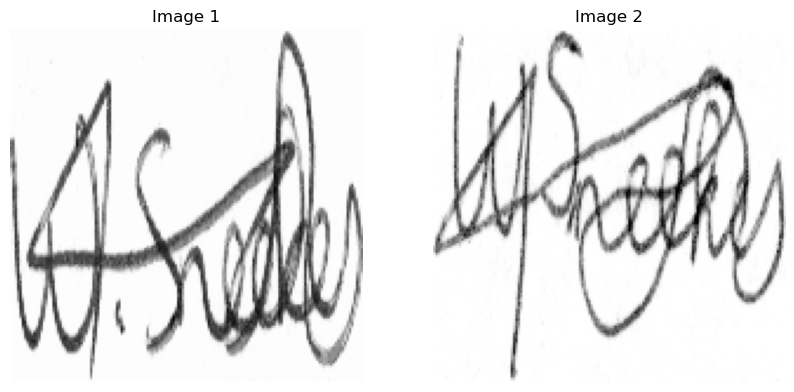

In [173]:
import random

# Получение случайных 10 индексов пар для вывода
random_indices = random.sample(range(len(test_pairs['image1'])), 10)

# Вывод случайных 10 пар изображений, их истинных меток и предсказанных меток
for i in random_indices:
    # Получение изображений
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    # Получение истинной метки и предсказанной метки
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    # Вывод информации
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    # Отображение изображений
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()

# Мои подписи

In [174]:

# Загрузка лучшей модели
model.load_weights("model.keras")

In [175]:

mytest_dir = "C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/my_test"
mytest_dataset = pd.read_csv('C:/Users/Vera/OneDrive/Документы/System Analysis/sign_class/sign_data_copy/mytest_data.csv', encoding='latin1', header = None)

In [176]:

generator_mytest = data_generator(mytest_dataset, mytest_dir, 6)

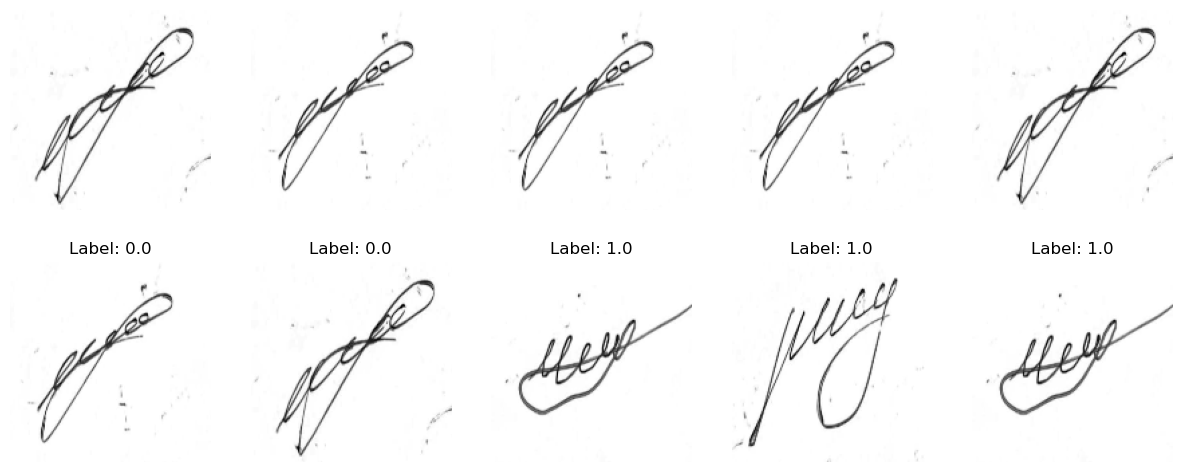

In [177]:
batch_images_my, batch_labels_my = next(generator_mytest)

# Отображаем первые пять пар изображений и их метки
plt.figure(figsize=(15, 6))
for i in range(5):
    # Получаем изображения и метку для текущей пары
    image1 = batch_images_my['image1'][i]
    image2 = batch_images_my['image2'][i]
    label = batch_labels_my[i]

    # Отображаем изображения
    plt.subplot(2, 5, i+1)
    plt.imshow(image1.squeeze(), cmap='gray')  # Отображаем изображение 1
    plt.axis('off')
#squeeze() используется для удаления размерности с единственным элементом (например, изображение может иметь размерность (1, 150, 150, 1), а squeeze() убирает размерность с единственным элементом, оставляя (150, 150)). plt.axis('off')
    plt.subplot(2, 5, i+6)
    plt.imshow(image2.squeeze(), cmap='gray')  # Отображаем изображение 2
    plt.axis('off')

    # Выводим метку
    plt.title(f"Label: {label}")

plt.show()


In [178]:
print("Image1 data shape:", batch_images_my["image1"].shape)
print("Image2 data shape:", batch_images_my["image2"].shape)
print("Label data shape:", batch_labels_my.shape)

Image1 data shape: (6, 150, 150, 1)
Image2 data shape: (6, 150, 150, 1)
Label data shape: (6,)


In [179]:
# Оценка модели на тестовом наборе
mytest_loss, mytest_accuracy = model.evaluate(generator_mytest,
                                                        steps=len(mytest_dataset) // 6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3333 - loss: 0.9166


In [180]:
print("Test Loss:", mytest_loss)
print("Test Accuracy:", mytest_accuracy)

Test Loss: 0.9165938496589661
Test Accuracy: 0.3333333432674408


In [181]:
# Получение пар изображений и их меток для тестового набора данных
test_pairs, test_labels = next(generator_mytest)

In [182]:
# Получение предсказаний для тестового набора данных
test_predictions = model.predict(test_pairs)

# Преобразование предсказаний в бинарный формат (0 или 1)
binary_predictions = (test_predictions > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


Pair 1
True Label: 0.0
Predicted Label: [0]


<Figure size 1500x600 with 0 Axes>

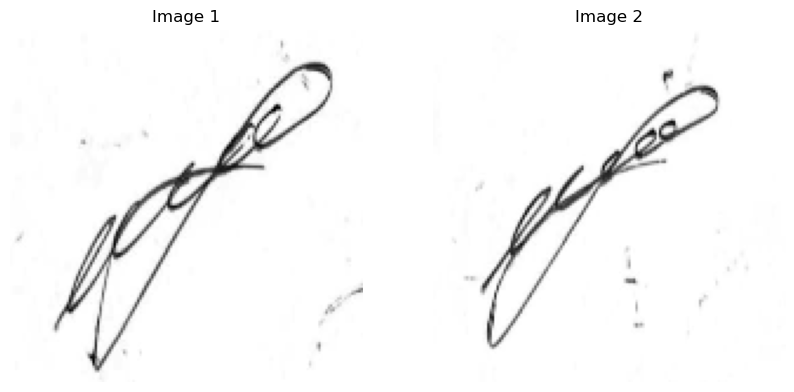

Pair 2
True Label: 0.0
Predicted Label: [0]


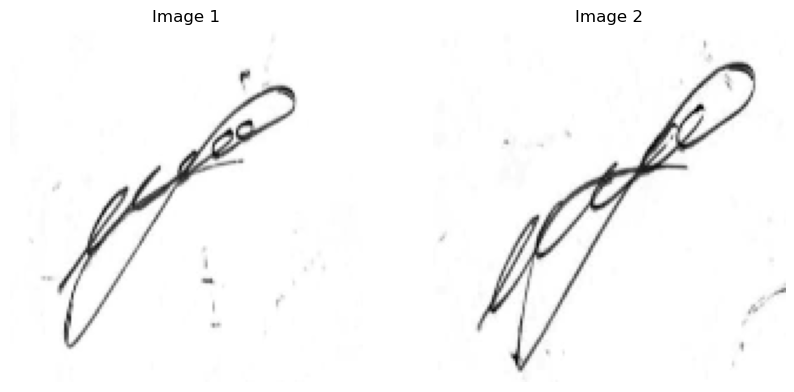

Pair 3
True Label: 1.0
Predicted Label: [0]


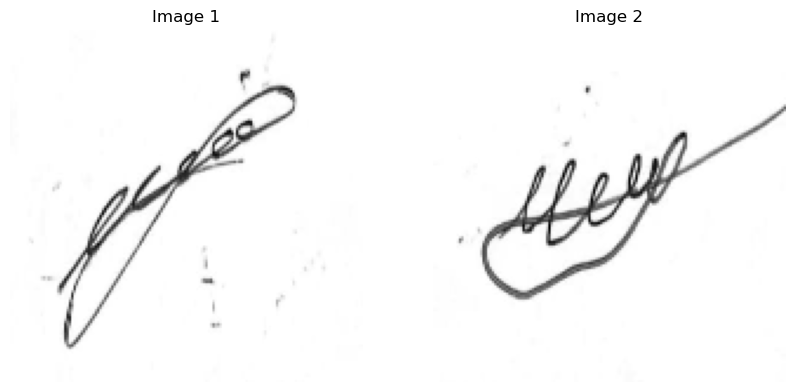

Pair 4
True Label: 1.0
Predicted Label: [0]


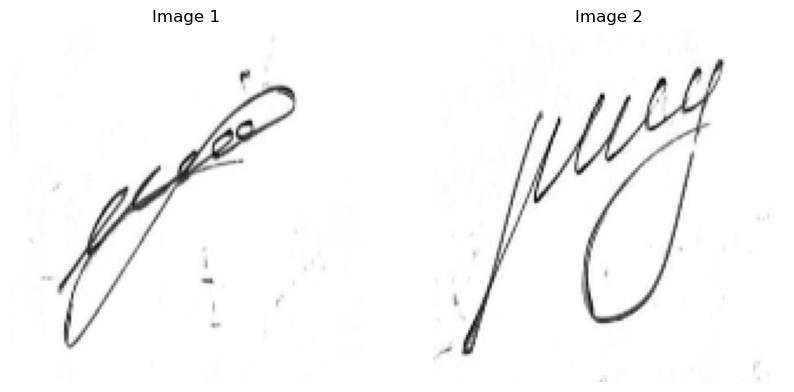

Pair 5
True Label: 1.0
Predicted Label: [0]


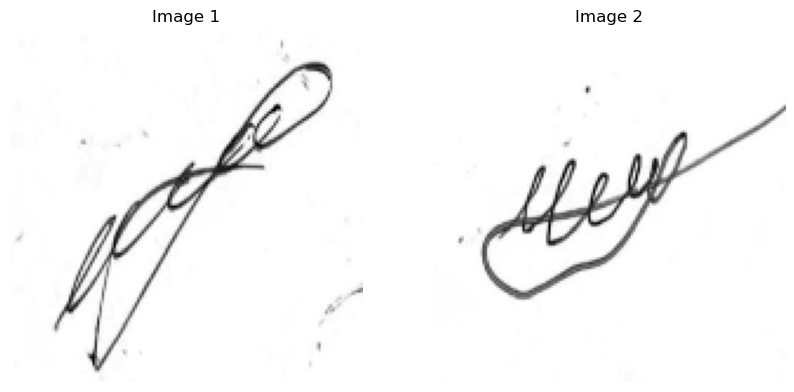

Pair 6
True Label: 1.0
Predicted Label: [0]


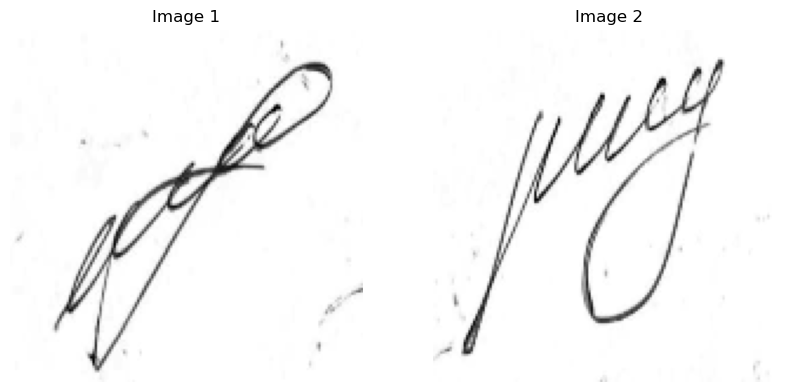

In [183]:

# Отображаем первые пять пар изображений и их метки
plt.figure(figsize=(15, 6))
for i in range(6):
    # Получение изображений
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    # Получение истинной метки и предсказанной метки
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    # Вывод информации
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    # Отображение изображений
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()
